
# Case Study: SMS Spam Classification


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 32.7 MB/s 


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Acquisition

Penjelasan Label 
* 0: SMS normal 
* 1: SMS fraud atau penipuan 
* 2: SMS promo

In [4]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-12-06 16:56:03--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.003s  

2022-12-06 16:56:03 (38.0 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv')

data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [7]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



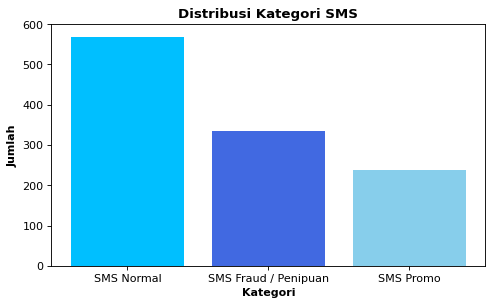

In [8]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# Text Preprocessing

## Case Folding

In [9]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [10]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


## Word Normalization

In [11]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-12-06 16:56:24--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.001s  

2022-12-06 16:56:24 (59.1 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [12]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [14]:
len(stopwords_ind)

758

In [15]:
# Lihat daftar stopword yang disediakan NLTK
# stopwords_ind

In [16]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [17]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


## Stemming

In [18]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [19]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming		:  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


## Text Preprocessing Pipeline

In [20]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [21]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 4min 25s, sys: 820 ms, total: 4min 26s
Wall time: 4min 27s


In [22]:
data

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,rupiah ribu spesial pilih aktif buru skb
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mbak kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau cas atay tranfer


In [23]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# Feature Engineering

In [24]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [25]:
X

0       promo beli paket flash my telkomsel app extra ...
1       rupiah ribu spesial pilih aktif promo sd novem...
2       pulang hormat sisa kuota flash kb download myt...
3       pulang hormat sisa kuota flash kb download myt...
4                rupiah ribu spesial pilih aktif buru skb
                              ...                        
1138                           yooo oke umumin grup kelas
1139                     nulis kerudung kirain warna jins
1140                                        mbak kirim ya
1141        nama beaok bwrangkat pagimau cas atay tranfer
1142                                       nomor bri nama
Name: clean_teks, Length: 1143, dtype: object

In [26]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1138    0
1139    0
1140    0
1141    0
1142    0
Name: label, Length: 1143, dtype: int64

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [28]:
#save model
import pickle

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Unigram
vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))
vec_TF_IDF.fit(X)

x_tf_idf = vec_TF_IDF.transform(X)

#Save vectorizer.vocabulary_
pickle.dump(vec_TF_IDF.vocabulary_,open("feature_tf-idf.sav","wb"))

In [29]:
#Menampilkan vocabulary dari TF-IDF
vec_TF_IDF.vocabulary_

{'promo': 2295,
 'beli': 323,
 'paket': 2088,
 'flash': 870,
 'my': 1880,
 'telkomsel': 2875,
 'app': 162,
 'extra': 841,
 'kuota': 1549,
 'lte': 1652,
 'telpon': 2878,
 'mnthr': 1831,
 'buru': 480,
 'cek': 521,
 'tselmemytsel': 3013,
 'sk': 2691,
 'rupiah': 2503,
 'ribu': 2452,
 'spesial': 2750,
 'pilih': 2175,
 'aktif': 66,
 'sd': 2557,
 'november': 1989,
 'pulang': 2330,
 'hormat': 1116,
 'sisa': 2684,
 'kb': 1410,
 'download': 752,
 'mytelkomsel': 1882,
 'apps': 167,
 'kuotabeli': 1550,
 'hubung': 1140,
 'skb': 2692,
 'ekstra': 804,
 'pulsa': 2332,
 'internet': 1220,
 'bulan': 466,
 'sjk': 2690,
 'augsept': 217,
 'detail': 665,
 'iring': 1242,
 'tarif': 2841,
 'panjang': 2101,
 'hits': 1105,
 'armada': 180,
 'curi': 600,
 'hati': 1069,
 'tekan': 2869,
 'okcall': 2041,
 'informasi': 1191,
 'eks': 801,
 'loh': 1639,
 'internetan': 1221,
 'pakai': 2086,
 'volume': 3129,
 'ultima': 3066,
 'mbhr': 1738,
 'harga': 1057,
 'tariflokasi': 2843,
 'tselmefl': 3011,
 'coboy': 568,
 'jr': 1329,

In [30]:
#Melihat Jumlah Fitur
print (len(vec_TF_IDF.get_feature_names_out()))

3253


In [31]:
#Melihat fitur-fitur apa saja yang ada di dalam corpus kita
print(vec_TF_IDF.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [32]:
#Lihat data tabular yang menggunakan metode TF-IDF
#Data ini siap untuk dimasukkan dalam proses machine learning

x1 = vec_TF_IDF.transform(X).toarray()
data_tabular_tf_idf= pd.DataFrame(x1,columns=vec_TF_IDF.get_feature_names_out())
data_tabular_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

In [33]:
#Mengubah nilai data tabular tf-idf & y dari dataframe menjdi array agar dapat dijalankan pada proses seleksi fitur
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

In [34]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k = 3000) 
X_kbest_features = chi2_features.fit_transform(x_train, y_train) 
  
# Reduced features 
print('Original feature number:', x_train.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 3253
Reduced feature number: 3000


In [35]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
Data =pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
Data

,Nilai
0,0.835608
1,0.419698
2,1.558607
3,0.716455
4,0.800674
...,...
3248,1.180239
3249,0.503162
3250,0.716455
3251,2.917381


In [36]:
#Menampilkan fitur beserta nilainya
feature =vec_TF_IDF.get_feature_names()
feature

Data['Fitur'] = feature
Data

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Nilai,Fitur
0,0.835608,aa
1,0.419698,aamiiiin
2,1.558607,aamiin
3,0.716455,ab
4,0.800674,abadi
...,...,...
3248,1.180239,zalora
3249,0.503162,zarkasi
3250,0.716455,zjt
3251,2.917381,zona


In [37]:
#Mengurutkan fitur terbaik
Data.sort_values(by='Nilai', ascending=False)

,Nilai,Fitur
2088,49.062970,paket
1030,46.324101,hadiah
1549,45.593560,kuota
2178,39.438431,pin
1486,34.448410,klik
...,...,...
1520,0.044910,kopi
307,0.044468,bca
1694,0.031579,maksimal
531,0.013783,cepat


In [38]:
#Menampilkan mask pada feature yang diseleksi
#False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask =chi2_features.get_support()
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [39]:
#Menampilkan fitur-fitur terpilih berdasarkan nilai mask atau nila tertinggi yang sudah ditetapkan pada Chi-Square
new_feature=[]
for bool,f in zip(mask,feature):
    if bool:
        new_feature.append(f)
    selected_feature=new_feature
selected_feature

['aa',
 'aamiiiin',
 'aamiin',
 'ab',
 'abadi',
 'abai',
 'abbee',
 'abdul',
 'acaratks',
 'account',
 'ada',
 'adapromo',
 'adi',
 'adik',
 'adison',
 'admin',
 'administrasi',
 'adminlte',
 'ado',
 'adrian',
 'adu',
 'aduh',
 'advertising',
 'aea',
 'aesthetic',
 'afbe',
 'affc',
 'afr',
 'afrika',
 'agam',
 'agen',
 'agendain',
 'agenpulsa',
 'ags',
 'agst',
 'agsts',
 'agt',
 'agtskinfodlj',
 'agua',
 'agun',
 'agus',
 'agust',
 'agustuskunjungi',
 'ahaha',
 'ahub',
 'aidzin',
 'aigoo',
 'air',
 'aja',
 'ajaa',
 'ajaaa',
 'ajabri',
 'ajak',
 'ajeng',
 'akang',
 'akangteteh',
 'akbar',
 'akreditasi',
 'akses',
 'aksi',
 'aktif',
 'aktifasi',
 'aktivasi',
 'aktivitas',
 'akucintaislam',
 'akumulasi',
 'akun',
 'akurasi',
 'akurat',
 'alaikum',
 'alaikumsaya',
 'alaiqum',
 'alam',
 'alamat',
 'alamsyah',
 'alesannya',
 'algoritma',
 'alhamdulillah',
 'alhuda',
 'ali',
 'aliando',
 'all',
 'allah',
 'allahaamiin',
 'alphard',
 'alquran',
 'alur',
 'aman',
 'amanda',
 'ambil',
 'amin',


In [40]:
# Membuat vocabulary baru berdasarkan fitur yang terseleksi
#Ini digunakan untuk mengenerate fitur vector tf-idf pada proses deployment

new_selected_features = {}

for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_features[k] = v

new_selected_features





{'promo': 2295,
 'beli': 323,
 'paket': 2088,
 'flash': 870,
 'my': 1880,
 'telkomsel': 2875,
 'app': 162,
 'extra': 841,
 'kuota': 1549,
 'lte': 1652,
 'telpon': 2878,
 'mnthr': 1831,
 'buru': 480,
 'cek': 521,
 'tselmemytsel': 3013,
 'sk': 2691,
 'rupiah': 2503,
 'ribu': 2452,
 'spesial': 2750,
 'pilih': 2175,
 'aktif': 66,
 'sd': 2557,
 'november': 1989,
 'pulang': 2330,
 'hormat': 1116,
 'sisa': 2684,
 'kb': 1410,
 'download': 752,
 'mytelkomsel': 1882,
 'apps': 167,
 'kuotabeli': 1550,
 'hubung': 1140,
 'skb': 2692,
 'ekstra': 804,
 'pulsa': 2332,
 'internet': 1220,
 'bulan': 466,
 'sjk': 2690,
 'augsept': 217,
 'detail': 665,
 'iring': 1242,
 'tarif': 2841,
 'panjang': 2101,
 'hits': 1105,
 'armada': 180,
 'curi': 600,
 'hati': 1069,
 'tekan': 2869,
 'okcall': 2041,
 'informasi': 1191,
 'eks': 801,
 'loh': 1639,
 'internetan': 1221,
 'pakai': 2086,
 'volume': 3129,
 'ultima': 3066,
 'mbhr': 1738,
 'harga': 1057,
 'tariflokasi': 2843,
 'tselmefl': 3011,
 'coboy': 568,
 'jr': 1329,

In [41]:
#Melihat jumlah fitur baru 
#Ini sesuai dengan nilai k pada chi-square
len(new_selected_features)

3000

In [42]:
#Save vectorizer.vocabulary_
#Menyimpan vektor dari vocabulary di atas dalam bentuk pickle (.pkl)
pickle.dump(new_selected_features,open("selected_feature_tf-idf.sav","wb"))

In [43]:
#Menampilkan Fitur-fitur yang sudah diseleksi 
#beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses Machine learning

#menampilkan fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features,columns=selected_feature)
data_selected_feature

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acaratks,account,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling (Machine Learning)

In [45]:
selected_x = X_kbest_features
selected_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
#Import Library
import random
from sklearn.model_selection import train_test_split

#Algoritme
#Algoritme yang dikomparasi
from sklearn import svm
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [47]:
x = selected_x
y = data.label
#Memisihkan data training dan data testing dengan perbandingan 80:20
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [48]:
#print
print('Banyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))

Banyak data x_train : 914
Banyak data x_test  : 229
Banyak data y_train : 914
Banyak data y_test  : 229


In [49]:
#Training Model

from datetime import datetime
start_time = datetime.now()
from joblib import dump
#algoritme fitting

text_algorithm = MultinomialNB()
#text_algorithm = svm.SVC(kernel="rbf", C=1.0)

model = text_algorithm.fit(x_train, y_train)

# save the model to disk
dump(model, filename="model_sentiment_naive.joblib")

end_time = datetime.now()
result_time  =end_time-start_time
print("Duration:",result_time)

#y_train

Duration: 0:00:00.016293


In [50]:
#Prediksi
predicted = model.predict(x_test)

#Hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted

array([0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 1,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0,
       0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1,
       2, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 1, 2,
       0, 1, 2, 1, 0, 2, 0, 1, 1])

# Model Evaluation

In [55]:
#Library evaluasi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Compute performance manually
NewprediksiBenar = (predicted == y_test).sum()
NewprediksiSalah = (predicted != y_test).sum()
    
print("prediksi benar: ", NewprediksiBenar, " data")
print("prediksi salah: ", NewprediksiSalah, " data")
print("Akurasi Algoritme: ", NewprediksiBenar/(NewprediksiBenar+NewprediksiSalah)*100,"%")

CM = confusion_matrix(y_test,predicted)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
precision    = TP/(TP+FP)
recall       = TP/(TP+FN)
print ("TRUE NEGATIVE (TN):",TN)
print ("FALSE NEGATIVE (FN):",FN)
print ("TRUE POSITIVE (TP):",TP)
print ("FALSE POSITIVE (FP):",FP)
print ("PRECISION:",precision*100,"%")
print ("RECALL:",recall*100,"%")
print(classification_report(y_test,predicted))

prediksi benar:  210  data
prediksi salah:  19  data
Akurasi Algoritme:  91.70305676855895 %
TRUE NEGATIVE (TN): 119
FALSE NEGATIVE (FN): 4
TRUE POSITIVE (TP): 59
FALSE POSITIVE (FP): 4
PRECISION: 93.65079365079364 %
RECALL: 93.65079365079364 %
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       126
           1       0.89      0.89      0.89        66
           2       0.84      0.86      0.85        37

    accuracy                           0.92       229
   macro avg       0.90      0.90      0.90       229
weighted avg       0.92      0.92      0.92       229



In [57]:
pickle.dump(model,open("model_fraud.sav", "wb"))

In [58]:
#Menggunakan Cross Validation untuk memvalidasi data

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv        = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
accuracy= (cross_val_score(model,x,y,cv=cv,scoring='accuracy'))
score_accuracy = np.mean(accuracy)
print ("accuracy: ",accuracy)
print ("accuracy: ",score_accuracy)

accuracy:  [0.92576419 0.91703057 0.93886463 0.93449782 0.90393013 0.93886463
 0.930131   0.930131   0.90829694 0.930131  ]
accuracy:  0.9257641921397379


# Deployment

In [59]:
from joblib import load
#Hasil
pipeline = load("model_sentiment_naive.joblib")

data_input = input("Masukkan sentiment:\n")
data_input = text_preprocessing_process(data_input)

#Load
tfidf = TfidfVectorizer


#loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(new_selected_features))
loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(pickle.load(open("selected_feature_tf-idf.sav", "rb"))))

hasil = pipeline.predict(loaded_vec.fit_transform([data_input]))

#print("Hasil Preprocessing:\n", proses)

if(hasil==0):
    s ="SMS Normal"
elif (hasil==1):
    s ="SMS Fraud"
else:
    s ="SMS Promo"
    
print("Hasil prediksi:\n", s) 

Masukkan sentiment:
	promo beli paket flash my telkomsel app extra kuota lte extra telpon mnthr buru cek tselmemytsel sk
Hasil prediksi:
 SMS Promo
